In [1]:
import os 
import datetime

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import glob
from tensorflow.compat.v1.train import summary_iterator as tf_summary_iterator
%matplotlib inline

In [98]:
alg = 'qmix'
policy_map_name = "5m_vs_6m"
eval_seeds = [1111111]
load_step = None

maps = [
        '3m', 
        '8m', 
        '5m_vs_6m',
        '8m_vs_9m', 
        '10m_vs_11m',  
        '25m', '27m_vs_30m'
       ]

checkpoint_names = [
#                     "qmix__attn__rnn__heads__orig_hidden-relu-pre-fchidden_temp=0.75_lr=.0005_xy_act__seed=112358__2021-05-15_17-01-13-210400",
                    "qmix__attn__old__temp=.75_dropout=.2_lr=.0005_xy_act__seed=112358__2021-05-18_14-44-19-596503",
                    "qmix__attn__old__temp=.75_dropout=.2_lr=.0005_xy_act__seed=1285842__2021-05-18_14-44-20-404310",
                    "qmix__attn__old__qmod__temp=.75_dropout=.2_lr=.0005_xy_act__seed=112358__2021-05-18_16-39-30-606774",
                    "qmix__attn__old__qmod__temp=.75_dropout=.2_lr=.0005_xy_act__seed=1285842__2021-05-18_17-24-19-551752",
                    "qmix__updet_train__seed=1285842__2021-05-20_15-47-27-608563",
                    "qmix__updet_train__seed=112358__2021-05-20_14-27-06-644926"
                    ] # models to check transfer for
results_dir = "/scratch/cluster/clw4542/results"
logs_basepath = "/scratch/cluster/clw4542/results/qmix_5m_vs_6m_transfer/tb_logs"

## Load TB Logs for Transfer 

In [24]:
env_name_standardizer = {
    "3m": "3m",
    "3": "3m",
    "5m_vs_6m": "5m_vs_6m",
    "5v6": "5m_vs_6m",
    "8m": "8m",
    "8": "8m",
    "8m_vs_9m": "8m_vs_9m",
    "8v9": "8m_vs_9m",
    "10m_vs_11m": "10m_vs_11m",
    "10v11": "10m_vs_11m"
}

def newest(path_list):
    '''Returns full path of newest file in given path'''
#     files = os.listdir(path)
#     paths = [os.path.join(path, basename) for basename in files]
    return max(path_list, key=os.path.getctime)

def extract_data_from_logs(logfile_path:str):
    res_dict = {}
    for summary in tf_summary_iterator(logfile_path):
#         print(summary)
        for v in summary.summary.value:
            res_dict[v.tag] = v.simple_value
    return res_dict

def get_eval_stats(checkpoint_name, eval_map_name, load_step, logs_basepath):
    log_basename = f'qmix__EVAL__{checkpoint_name.strip("/ ")}__ENV={eval_map_name}__STEP={load_step}__*'
    log_folder = os.path.join(logs_basepath, log_basename)

    # there may be multiple eval folders corresponding to same log; take latest
    log_folders = glob.glob(log_folder, recursive=True)
    newest_log_folder = newest(log_folders)
    full_log_path = glob.glob(newest_log_folder + "/*", recursive=True)[0]
#     print(full_log_path)
    results_dict = extract_data_from_logs(full_log_path)
    return results_dict

# checkpoint_name = "qmix__attn__old__temp=.75_dropout=.2_lr=.0005_xy_act__seed=112358__2021-05-18_14-44-19-596503"
# eval_map_name = "5m_vs_6m"
# load_step = 25 #2000148 

# results_dict = get_eval_stats(checkpoint_name, eval_map_name, load_step, logs_basepath)
# results_dict['test_battle_won_mean']

# extract_data_from_logs('/scratch/cluster/clw4542/results/qmix_5m_vs_6m/tb_logs/qmix__TRANSFEREVAL__seed=1111111__2021-05-20_11-44-50-849074/events.out.tfevents.1621529107.dgx-1')

{'test_return_mean': 16.55094337463379,
 'test_return_std': 4.5559282302856445,
 'test_battle_won_mean': 0.6307692527770996,
 'test_dead_allies_mean': 3.2153847217559814,
 'test_dead_enemies_mean': 5.523077011108398,
 'test_ep_length_mean': 25.830768585205078,
 'epsilon': 0.0}

## Zero-Shot Transfer Plots

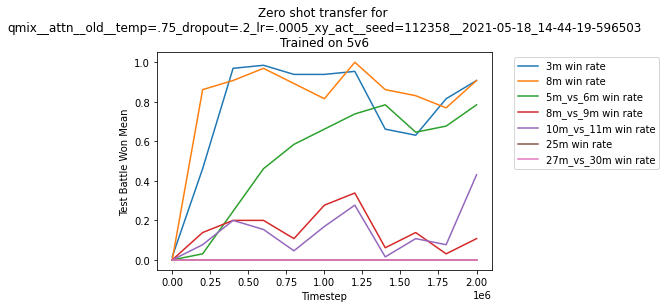

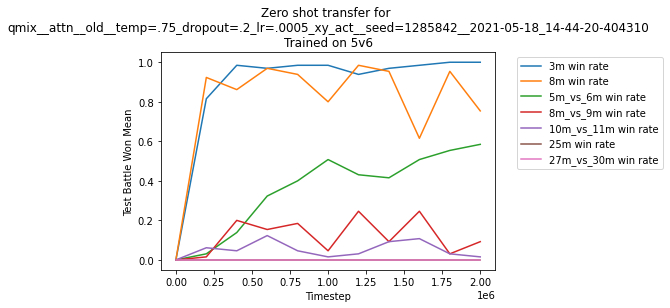

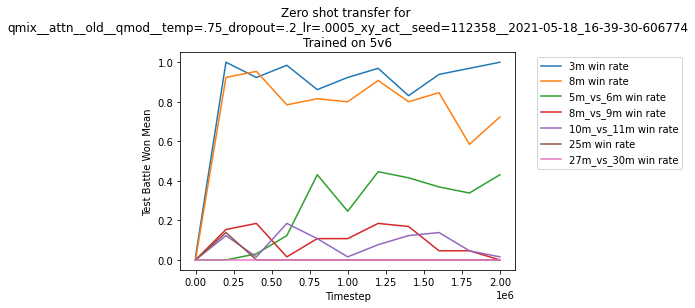

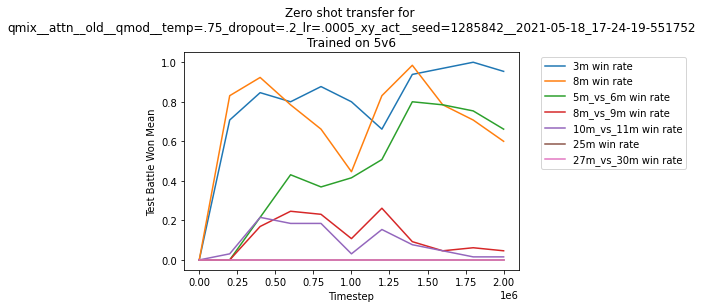

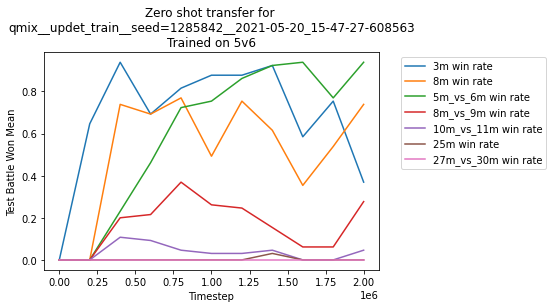

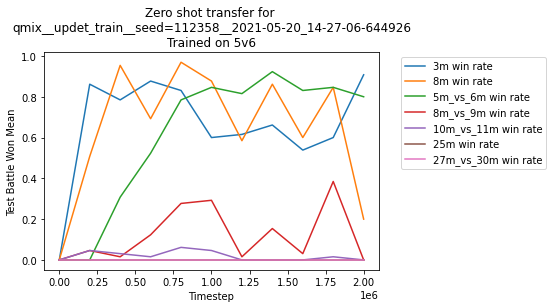

In [99]:
results_dict = {}
for checkpoint_name in checkpoint_names:
    results_dict[checkpoint_name] = {}
    
    plt.figure()
    plt.title(f"Zero shot transfer for \n{checkpoint_name}\nTrained on 5v6")
    plt.xlabel("Timestep")
#     plt.ylabel("Test Return Mean")
    plt.ylabel("Test Battle Won Mean")

    for eval_map_name in maps:
        results_dict[checkpoint_name][eval_map_name] = {"ts": [], "test_battle_won_mean": [], "test_return_mean": []}
        
        # grep through saved model checkpoints to get the timestep
        checkpoint_model_path = os.path.join(results_dir, f"{alg}_{policy_map_name}", "models", checkpoint_name)
        assert os.path.exists(checkpoint_model_path), f"Unable to find checkpointed model for {checkpoint_name}"
        for ckpt_dir_path in glob.glob(checkpoint_model_path + "/*", recursive=True): 
            ckpt_timestep = int(os.path.basename(ckpt_dir_path))
            battle_stats = get_eval_stats(checkpoint_name=checkpoint_name, eval_map_name=eval_map_name, 
                                          load_step=ckpt_timestep, logs_basepath=logs_basepath)
            results_dict[checkpoint_name][eval_map_name]["ts"].append(ckpt_timestep)
            results_dict[checkpoint_name][eval_map_name]["test_battle_won_mean"].append(battle_stats['test_battle_won_mean'])
#             results_dict[checkpoint_name][eval_map_name]["test_return_mean"].append(battle_stats['test_return_mean'])
    
        transfer_res = results_dict[checkpoint_name][eval_map_name]
        plt.plot(transfer_res['ts'], transfer_res['test_battle_won_mean'], label=eval_map_name + " win rate")
#         plt.plot(transfer_res['ts'], transfer_res['test_return_mean'], label=eval_map_name + " return")
        plt.legend(bbox_to_anchor=(1.05, 1))
        
        

## Visualize Results Table

In [ ]:
def get_num_agents_from_name(name_col:str):
    '''Assume name is in format alg__{policy_map_name}__to__{eval_map_name}
    '''
    alg, policy_map_name, _, eval_map_name = name_col.split("__")
    policy_namelist = policy_map_name.split("_")
    eval_namelist = eval_map_name.split("_")
    
    if len(policy_namelist) == 1: 
        n_policy_agents = n_policy_enemies = int(policy_namelist[0].strip("m"))
    else: 
        n_policy_agents, _, n_policy_enemies = policy_namelist
        n_policy_agents = int(n_policy_agents.strip("m"))
        n_policy_enemies = int(n_policy_enemies.strip("m"))
        
    if len(eval_namelist) == 1: 
        n_eval_agents = n_eval_enemies = int(eval_namelist[0].strip("m"))
    else: 
        n_eval_agents, _, n_eval_enemies = eval_namelist
        n_eval_agents = int(n_eval_agents.strip("m"))
        n_eval_enemies = int(n_eval_enemies.strip("m"))    
        
    return n_policy_agents, n_policy_enemies, n_eval_agents, n_eval_enemies, alg, policy_map_name, eval_map_name

# change formatting of row names 
res_df = pd.DataFrame.from_dict(res_dict, orient='index').reset_index()
id_cols = (res_df['index'].astype(str)
                          .apply(get_num_agents_from_name)
                          .apply(pd.Series)
          )

# reorder columns
res_df[['n_policy_agents', 'n_policy_enemies', 'n_eval_agents', 'n_eval_enemies', 
        'alg', 'policy_map', 'eval_map']] = id_cols
res_df = res_df.drop('index', axis=1)
res_df_columns = res_df.columns.tolist()
reordered_cols = res_df_columns[-3:] + res_df_columns[:-3]
res_df = res_df[reordered_cols]

res_df[['alg', 'policy_map', 'eval_map', 'test_return_mean', 'test_return_std', 'test_battle_won_mean', 
       'test_dead_enemies_mean', 'test_dead_allies_mean', 'test_ep_length_mean']]

In [ ]:
res_df.to_csv("baselines_transfer.csv")